<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/getting_started_semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started with Semantic Segmentation using IceVision

![](../images/mmsegmentation-camvid.png)

## Introduction
IceVision is a Framework for object detection and segmentation that makes it easier to prepare data, train an object detection or segmentation model, and use that model for inference.

The IceVision Framework provides a layer across multiple deep learning engines, libraries, models, and data sets.

It enables you to work with multiple training engines, including [fastai](https://github.com/fastai/fastai), and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning).

It enables you to work with some of the best deep learning libraries including, [mmdetection](https://arxiv.org/abs/1906.07155), [mmsegmentation](https://github.com/open-mmlab/mmsegmentation), [Ross Wightman's efficientdet implementation](https://github.com/rwightman/efficientdet-pytorch) and model library, [torchvision](https://pytorch.org/vision/stable/index.html), and [ultralytics Yolo](https://github.com/ultralytics/yolov5).

It enables you to select from many possible model types and backbones from these libraries.

IceVision lets you switch between them with ease. This means that you can pick the engine, library, model, and data format that work for you now and easily change them in the future. You can experiment with with them to see which ones meet your requirements.

In this tutorial, you will learn how to  
1. Install IceVision. This will include the IceData package that provides easy access to several sample datasets, as well as the engines and libraries that IceVision works with.  
2. Download and prepare a dataset to work with.  
3. Select a segmentation model type and backbone.  
4. Instantiate the model, and then train it with both the fastai engine (pytorch lightning coming soon!).  
5. And finally, use the model to segment images.  

The notebook is set up so that you can easily select different model types and backbones to try.

## Install IceVision and IceData
The following downloads and runs a short shell script. The script installs IceVision, IceData, the MMDetection library, and Yolo v5 as well
as the fastai and pytorch lightning engines.

In [ ]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
!bash install_colab.sh

## Imports
All of the IceVision components can be easily imported with a single line.


In [2]:
from icevision.all import *

INFO     - The mmseg config folder already exists. No need to downloaded it. Path : /home/ubuntu/.icevision/mmsegmentation_configs/mmsegmentation_configs-0.17.0/configs | icevision.models.mmseg.download_configs:download_mmseg_configs:20


## Download and prepare a dataset
Now we can start by downloading a subset of the CamVid dataset. This tiny dataset contains 100 images acquired from the perspective of a driving car for which pixels are segmented in 32 classes including:
- Road
- Sky
- Tree

IceVision provides methods to load a dataset, parse annotation files, and more.

In [3]:
# Download the dataset
url = "https://s3.amazonaws.com/fast-ai-sample/camvid_tiny.tgz"
data_dir = icedata.load_data(url, "camvid_tiny") / "camvid_tiny"
images_dir = data_dir / "images"
labels_dir = data_dir / "labels"

## Parse the dataset

The record is a key concept in IceVision, it holds the information about an image and its annotations. It is extensible and can support other formats and types of annotations (including bounding boxes and masks).

In our case, we have images where each pixel is annotated with 1 of 32 classes, represented as integer pixel values. We first create a class map that will represent how a given pixel value is mapped to a class.

In [4]:
# Load the codes associated with the images, and create a class map
codes = np.loadtxt(data_dir / "codes.txt", dtype=str)
class_map = ClassMap(list(codes))

The next step consists in creating records based on the images files we downloaded. For this, we use the helper method `get_image_files` to get the path of our images.

A `RecordCollection` object is created, and our record will be of type `SemanticSegmentationRecord`. This is important. as this will instruct `IceVision` to expect record that include an original image as well as semantic segmentation masks (our labels).

For each image, we create a new record that include the path to the raw image, sets its size, and the associated class map. Finally, the mask containing our labels is added to the record.

In [5]:
# Create records

# Get paths to all images
image_files = get_image_files(images_dir)

# Create a collection of records
records = RecordCollection(SemanticSegmentationRecord)

for image_file in pbar(image_files):
    record = records.get_by_record_id(image_file.stem)

    if record.is_new:
        # Set path to raw image
        record.set_filepath(image_file)
        # Set size of image
        record.set_img_size(get_img_size(image_file))
        # Associated image with the CamVid class map
        record.segmentation.set_class_map(class_map)

    # Load and set the segmentation mask containing labels
    mask_file = SemanticMaskFile(labels_dir / f"{image_file.stem}_P.png")
    record.segmentation.set_mask(mask_file)

  0%|          | 0/100 [00:00<?, ?it/s]

We can use the magic `autofix()` method to make sure that our collection of records was built correctly.

Once we are satisfied everything is OK, we split our collection of records into train and validation.

In [6]:
records = records.autofix()
train_records, valid_records = records.make_splits(RandomSplitter([0.8, 0.2]))

  0%|          | 0/100 [00:00<?, ?it/s]

## Creating datasets with agumentations and transforms

Data augmentations are essential for robust training and results on many datasets and deep learning tasks. IceVision ships with the [Albumentations](https://albumentations.ai/docs/) library for defining and executing transformations, but can be extended to use others.

For this tutorial, we apply the Albumentation's default `aug_tfms` to the training set. `aug_tfms` randomly applies broadly useful transformations including rotation, cropping, horizintal flips, and more. See the Albumentations documentation to learn how to customize each transformation more fully.

The validation set is only resized (with padding).

We then create `Datasets` for both. The dataset applies the transforms to the annotations (in this case, segmentation masks) and images in the data records.

In [10]:
presize, size = 520, 480
presize, size = ImgSize(presize, int(presize * 0.75)), ImgSize(size, int(size * 0.75))

aug_tfms = tfms.A.aug_tfms(
    presize=presize,
    size=size,
    pad=None,
    crop_fn=partial(tfms.A.RandomCrop, p=0.5),
    shift_scale_rotate=tfms.A.ShiftScaleRotate(rotate_limit=20),
)
train_tfms = tfms.A.Adapter([*aug_tfms, tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([tfms.A.resize(size), tfms.A.Normalize()])

In [11]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

### Understanding the transforms

The Dataset transforms are only applied when we grab (get) an item. Several of the default `aug_tfms` have a random element to them. For example, one might perform a rotation with probability 0.5 where the angle of rotation  is randomly selected between +45 and -45 degrees.

This means that the learner sees a slightly different version of an image each time it is accessed. This effectively increases the size of the dataset and improves learning.

We can look at result of getting the 0th image from the dataset a few times and see the differences. Each time you run the next cell, you will see different results due to the random element in applying transformations.

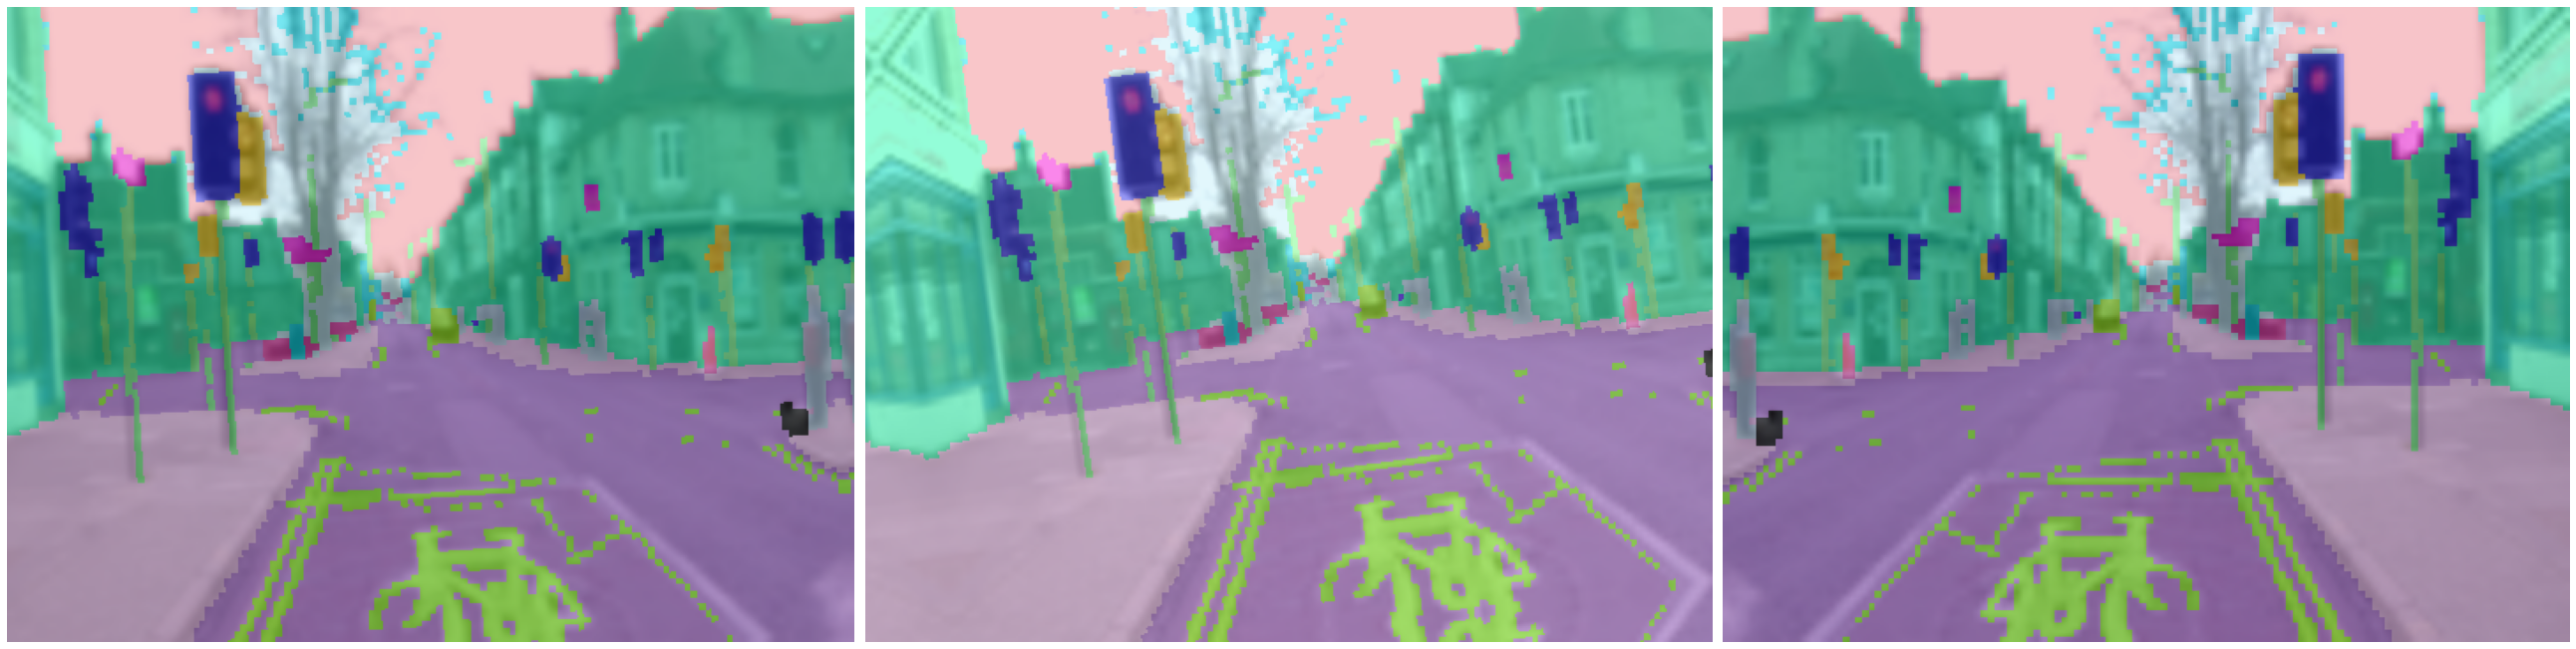

In [13]:
# Show an element of the train_ds with augmentation transformations applied
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

## Select a library, model, and backbone

In order to create a model, we need to:
* Choose one of the **libraries** supported by IceVision
* Choose one of the **models** supported by the library
* Choose one of the **backbones** corresponding to a chosen model

You can access any supported models by following the IceVision unified API, use code completion to explore the available models for each library.



### Creating a model
Selections only take two simple lines of code. For example, to try the `mmsegmentation` library using the `DeepLabV3` model and the `resnet50_d8` backbone  could be specified by:
```
model_type = models.mmseg.deeplabv3
backbone = model_type.backbones.resnet50_d8
```

As pretrained models are used by default, we typically leave this out of the backbone creation step.

We've selected a few of the many options below. You can easily pick which option you want to try by setting the value of `selection`. This shows you how easy it is to try new libraries, models, and backbones.


In [15]:
# Just change the value of selection to try another model

selection = 0

extra_args = {}

if selection == 0:
  # DeepLabV3
  model_type = models.mmseg.deeplabv3
  backbone = model_type.backbones.resnet50_d8

elif selection == 1:
  # DeepLabV3Plus
  model_type = models.mmseg.deeplabv3plus
  backbone = model_type.backbones.resnet50_d8

model_type, backbone, extra_args

(<module 'icevision.models.mmseg.models.deeplabv3' from '/home/ubuntu/icevision/icevision/models/mmseg/models/deeplabv3/__init__.py'>,
 {})

In [ ]:
backbone.__dict__

Now it is just a one-liner to instantiate the model. If you want to try another *option*, just edit the line at the top of the previous cell.

In [17]:
# Instantiate the model
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(class_map), **extra_args) 

INFO     - Loaded default configuration for deeplabv3 with R-50-D8 backbone (Pre-training dataset = cityscapes, learning schedule = 80k, crop size = (512, 1024)) | icevision.models.mmseg.common.utils:build_model:54


  0%|          | 0/272761183 [00:00<?, ?B/s]

/home/ubuntu/icevision/.env/lib/python3.7/site-packages/mmseg/models/backbones/resnet.py:428: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
2021-10-07 08:26:51,489 - mmcv - INFO - initialize ResNetV1c with init_cfg {'type': 'Pretrained', 'checkpoint': 'open-mmlab://resnet50_v1c'}
2021-10-07 08:26:51,490 - mmcv - INFO - load model from: open-mmlab://resnet50_v1c
2021-10-07 08:26:51,490 - mmcv - INFO - Use load_from_openmmlab loader
2021-10-07 08:26:51,833 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2021-10-07 08:26:51,860 - mmcv - INFO - initialize ASPPHead with init_cfg {'type': 'Normal', 'std': 0.01, 'override': {'name': 'conv_seg'}}
2021-10-07 08:26:52,001 - mmcv - INFO - initialize FCNHead with init_cfg {'type': 'Normal', 'std': 0.01, 'override': {'name': 'conv_seg'}}
2021-10-07 08:26:52,

2021-10-07 08:26:52,049 - mmcv - INFO - 
backbone.layer2.0.downsample.1.weight - torch.Size([512]): 
PretrainedInit: load from open-mmlab://resnet50_v1c 
 
2021-10-07 08:26:52,049 - mmcv - INFO - 
backbone.layer2.0.downsample.1.bias - torch.Size([512]): 
PretrainedInit: load from open-mmlab://resnet50_v1c 
 
2021-10-07 08:26:52,050 - mmcv - INFO - 
backbone.layer2.1.conv1.weight - torch.Size([128, 512, 1, 1]): 
PretrainedInit: load from open-mmlab://resnet50_v1c 
 
2021-10-07 08:26:52,054 - mmcv - INFO - 
backbone.layer2.1.bn1.weight - torch.Size([128]): 
PretrainedInit: load from open-mmlab://resnet50_v1c 
 
2021-10-07 08:26:52,055 - mmcv - INFO - 
backbone.layer2.1.bn1.bias - torch.Size([128]): 
PretrainedInit: load from open-mmlab://resnet50_v1c 
 
2021-10-07 08:26:52,056 - mmcv - INFO - 
backbone.layer2.1.conv2.weight - torch.Size([128, 128, 3, 3]): 
PretrainedInit: load from open-mmlab://resnet50_v1c 
 
2021-10-07 08:26:52,057 - mmcv - INFO - 
backbone.layer2.1.bn2.weight - torch.

2021-10-07 08:26:52,102 - mmcv - INFO - 
backbone.layer3.2.bn2.bias - torch.Size([256]): 
PretrainedInit: load from open-mmlab://resnet50_v1c 
 
2021-10-07 08:26:52,102 - mmcv - INFO - 
backbone.layer3.2.conv3.weight - torch.Size([1024, 256, 1, 1]): 
PretrainedInit: load from open-mmlab://resnet50_v1c 
 
2021-10-07 08:26:52,103 - mmcv - INFO - 
backbone.layer3.2.bn3.weight - torch.Size([1024]): 
PretrainedInit: load from open-mmlab://resnet50_v1c 
 
2021-10-07 08:26:52,104 - mmcv - INFO - 
backbone.layer3.2.bn3.bias - torch.Size([1024]): 
PretrainedInit: load from open-mmlab://resnet50_v1c 
 
2021-10-07 08:26:52,104 - mmcv - INFO - 
backbone.layer3.3.conv1.weight - torch.Size([256, 1024, 1, 1]): 
PretrainedInit: load from open-mmlab://resnet50_v1c 
 
2021-10-07 08:26:52,105 - mmcv - INFO - 
backbone.layer3.3.bn1.weight - torch.Size([256]): 
PretrainedInit: load from open-mmlab://resnet50_v1c 
 
2021-10-07 08:26:52,106 - mmcv - INFO - 
backbone.layer3.3.bn1.bias - torch.Size([256]): 
Pr

2021-10-07 08:26:52,157 - mmcv - INFO - 
backbone.layer4.2.conv2.weight - torch.Size([512, 512, 3, 3]): 
PretrainedInit: load from open-mmlab://resnet50_v1c 
 
2021-10-07 08:26:52,158 - mmcv - INFO - 
backbone.layer4.2.bn2.weight - torch.Size([512]): 
PretrainedInit: load from open-mmlab://resnet50_v1c 
 
2021-10-07 08:26:52,159 - mmcv - INFO - 
backbone.layer4.2.bn2.bias - torch.Size([512]): 
PretrainedInit: load from open-mmlab://resnet50_v1c 
 
2021-10-07 08:26:52,160 - mmcv - INFO - 
backbone.layer4.2.conv3.weight - torch.Size([2048, 512, 1, 1]): 
PretrainedInit: load from open-mmlab://resnet50_v1c 
 
2021-10-07 08:26:52,161 - mmcv - INFO - 
backbone.layer4.2.bn3.weight - torch.Size([2048]): 
PretrainedInit: load from open-mmlab://resnet50_v1c 
 
2021-10-07 08:26:52,162 - mmcv - INFO - 
backbone.layer4.2.bn3.bias - torch.Size([2048]): 
PretrainedInit: load from open-mmlab://resnet50_v1c 
 
2021-10-07 08:26:52,163 - mmcv - INFO - 
decode_head.conv_seg.weight - torch.Size([33, 512, 1

Use load_from_local loader
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([33, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([33]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([33, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([33]).


## Data Loader

The Data Loader is specific to a model_type. The job of the data loader is to get items from a dataset and batch them up in the specific format required by each model. This is why creating the data loaders is separated from creating the datasets.

We can take a look at the first batch of items from the `valid_dl`. Remember that the `valid_tfms` only resized (with padding) and normalized records, so different images, for example, are not returned each time. This is important to provide consistent validation during training.

In [18]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

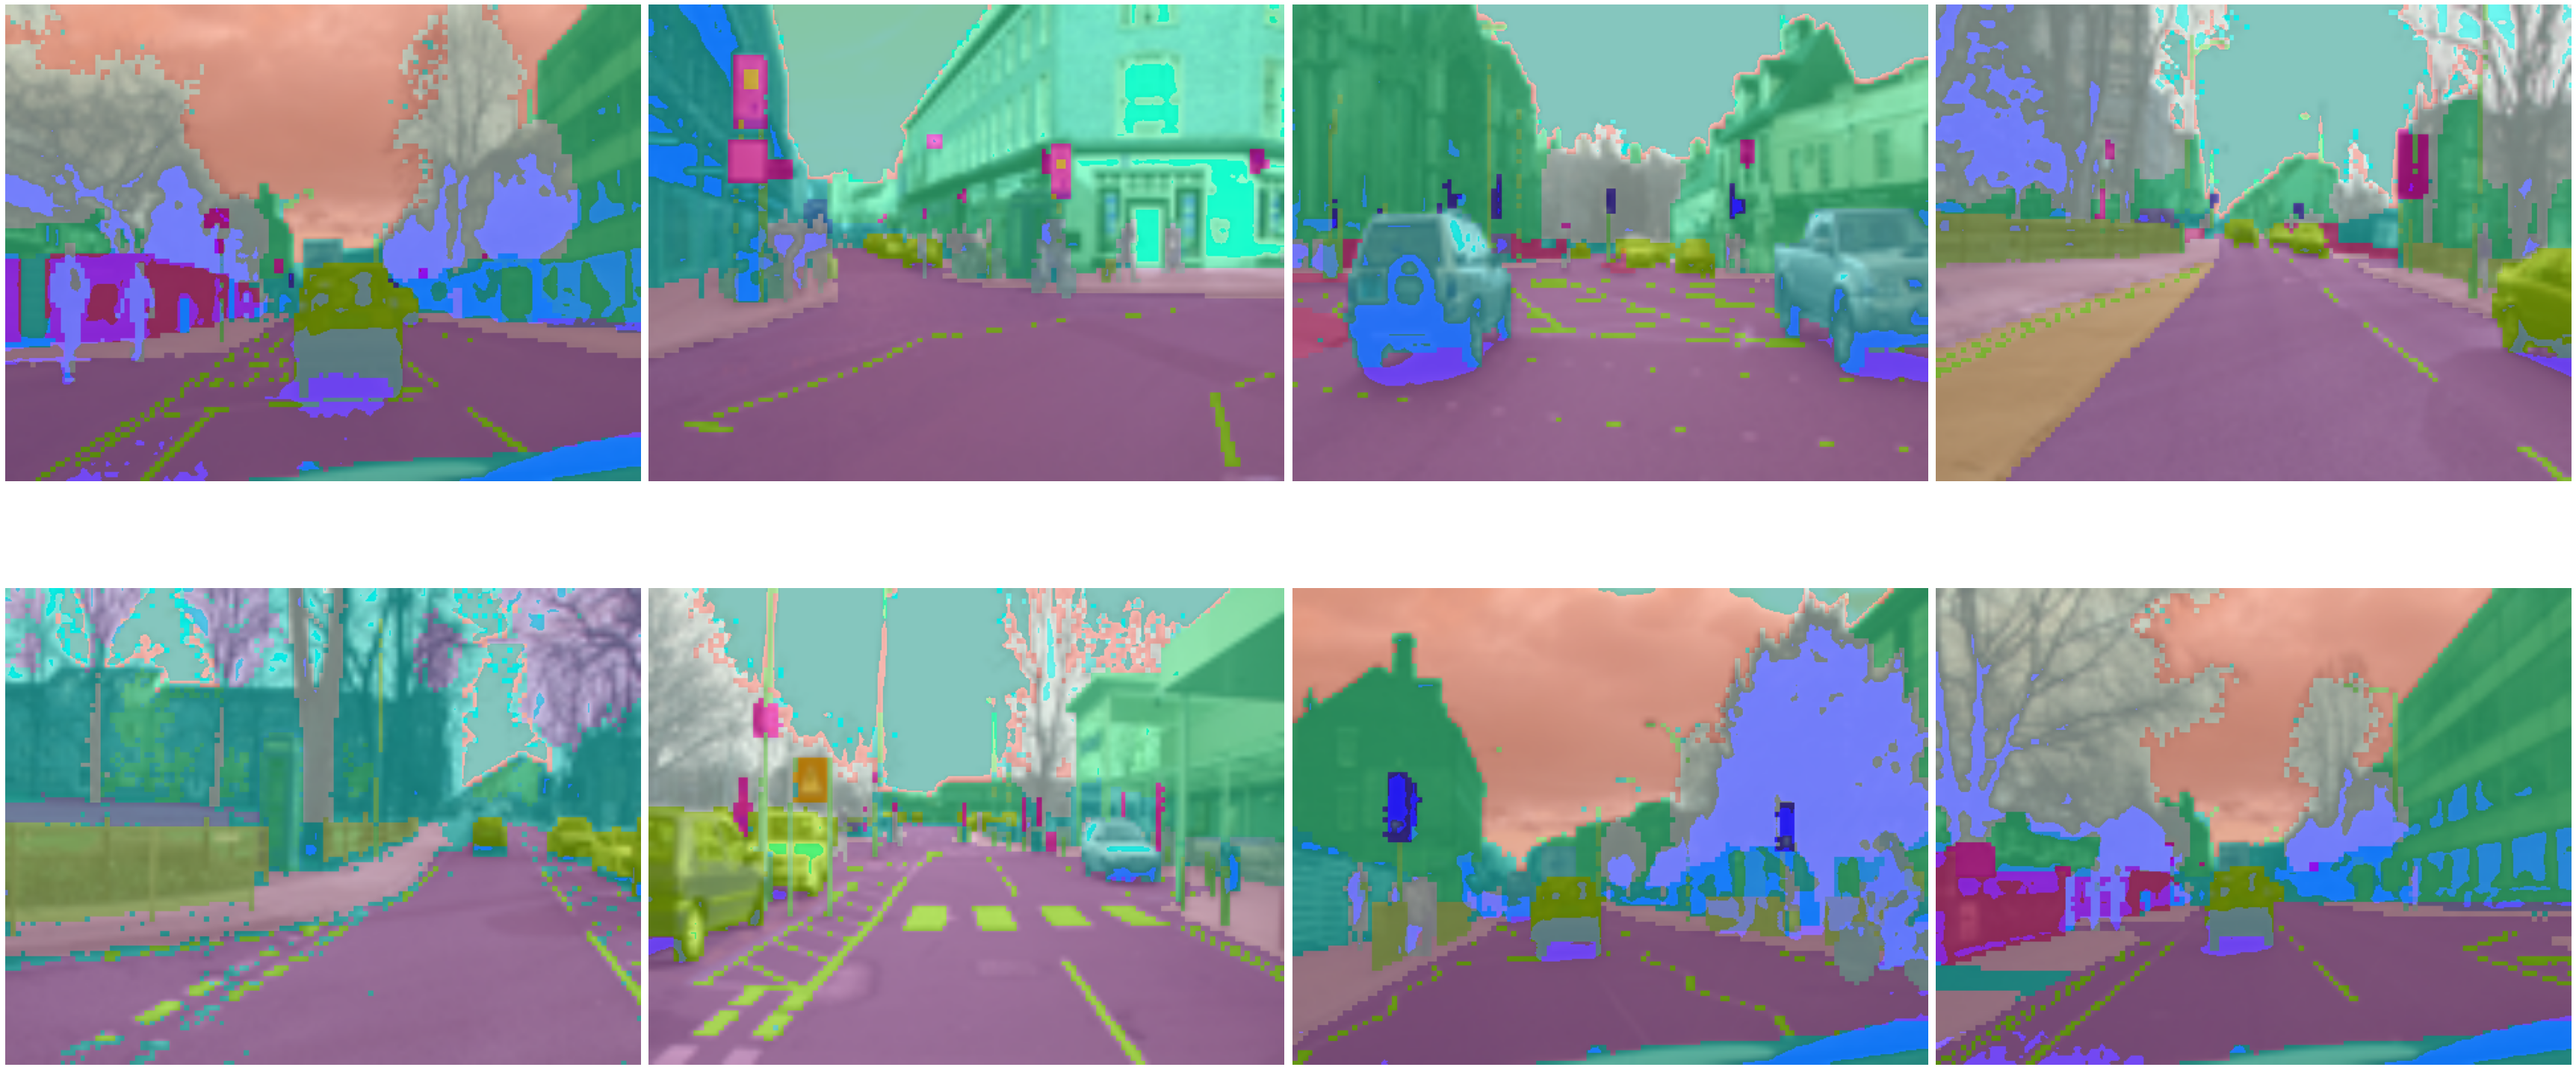

In [19]:
# show batch
model_type.show_batch(first(valid_dl), ncols=4)

## Metrics

The fastai and pytorch lightning engines collect metrics to track progress during training. IceVision provides metric classes that work across the engines and libraries.

The same metrics can be used for both fastai and pytorch lightning.

In [25]:
metrics = [MulticlassDiceCoefficient()]

## Training

IceVision is an agnostic framework meaning it can be plugged into other DL learning engines such as [fastai2](https://github.com/fastai/fastai2), and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning).  


### Training using fastai

In [26]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.005248074419796467)

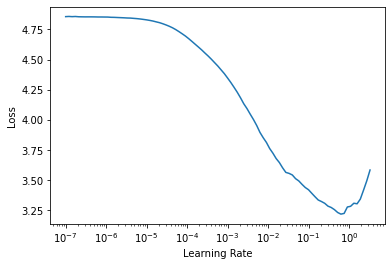

In [22]:
learn.lr_find()

In [27]:
learn.fine_tune(20, 0.1, freeze_epochs=1)

### Training using Pytorch Lightning (Coming Soon!)

## Using the model - inference and showing results

The first step in reviewing the model is to show results from the validation dataset. This is easy to do with the `show_results` function.

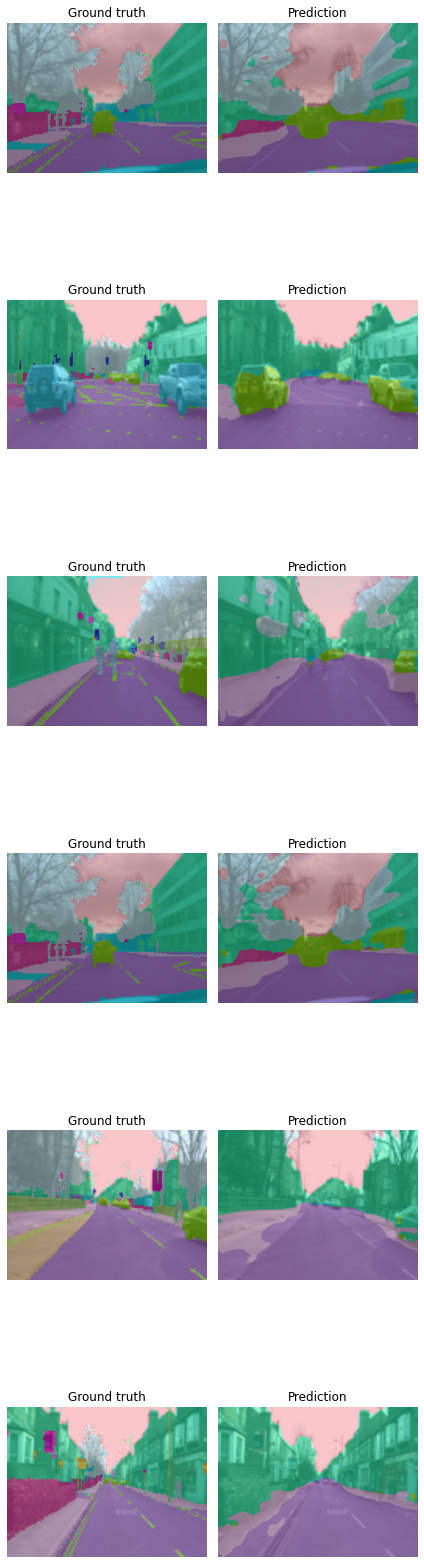

In [28]:
model_type.show_results(model, valid_ds)

### Prediction

Sometimes you want to have more control than `show_results` provides. You can construct an inference dataloader using `infer_dl` from any IceVision dataset and pass this to `predict_dl` and use `show_preds` to look at the predictions.

A prediction is returned as a dict with keys: `scores`, `labels`, `bboxes`, and possibly `masks`. 

Prediction functions that take a `detection_threshold` argument will only return the predictions whose score is above the threshold.

Prediction functions that take a `keep_images` argument will only return the (tensor representation of the) image when it is `True`. In interactive environments, such as a notebook, it is helpful to see the image with bounding boxes and labels applied. In a deployment context, however, it is typically more useful (and efficient) to return the bounding boxes by themselves.



> NOTE: For a more detailed look at inference check out the [inference tutorial](https://airctic.com/dev/inference/)

In [29]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

  0%|          | 0/5 [00:00<?, ?it/s]

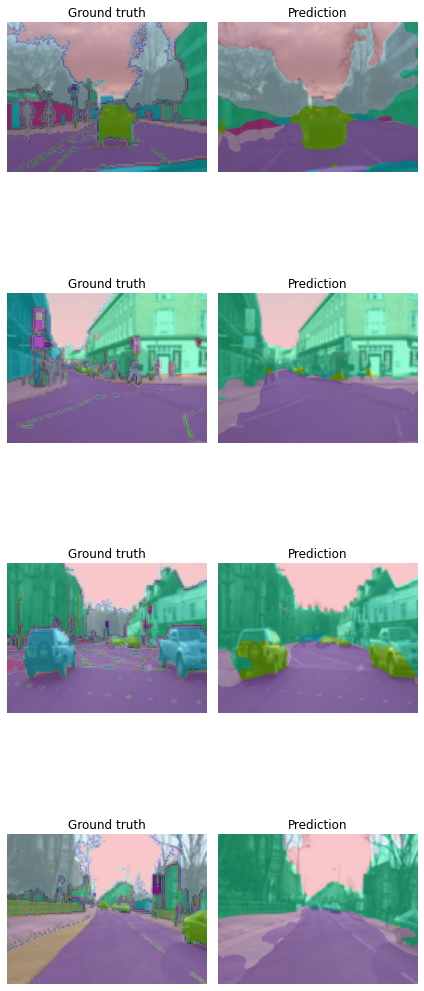

In [30]:
show_preds(preds=preds[:4])

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://discord.gg/JDBeZYK).